# <center> Методы оптимизации проектных решений
<!-- Пчелкин Дмитрий БИВ-155 -->
Содержание:
1. [Численные методы решения СЛАУ](#1.-Численные-методы-решения-СЛАУ)
2. [Градиент](#2.-Градиент)
3. [Гессиан](#3.-Гессиан)

## 1. Численные методы решения СЛАУ
Рассмотрим некоторые численные методы решения [систем линейных алгебраических уравнений](https://ru.wikipedia.org/wiki/Система_линейных_алгебраических_уравнений) на примере расчета электрических цепей [методом узловых потенциалов](https://ru.wikipedia.org/wiki/Метод_узловых_потенциалов).

In [15]:
import logging
import numpy as np
import scipy
import scipy.linalg
from time import time

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rc('font', family='Arial')
plt.style.use('ggplot')

import sympy
sympy.init_printing()

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

logging.basicConfig(level=logging.INFO)

Реализация методов решения СЛАУ:
* [метод Крамера](https://ru.wikipedia.org/wiki/Метод_Крамера);
* [метод Гаусса-Жордана](https://ru.wikipedia.org/wiki/Метод_Гаусса_—_Жордана) - модификация [метода Гаусса](https://ru.wikipedia.org/wiki/Метод_Гаусса);
* [матричный метод](https://ru.wikipedia.org/wiki/Матричный_метод).

In [3]:
class LinearSolver:
    """ Реализация численных методов решения СЛАУ """
    @staticmethod
    def is_solvable(A: np.ndarray) -> bool:
        """ Проверка существования решения СЛАУ """
        if np.subtract(*A.shape):
            logging.error("Incorrect equation matrix: %s!", A.shape)
            return False
        det = scipy.linalg.det(A)
        if not det:
            logging.error("Can't solve linear equation by Kramer method: det == %d.", det)
            return False
        logging.debug("Equation can be solved.")
        return True
    
    @staticmethod
    def swap(x: np.ndarray, idx: int, jdx: int, axis: int=0) -> np.ndarray:
        """ Меняет строки/столбцы местами """
        if idx == jdx:
            logging.debug("idx(%d) == jdx(%d)", idx, jdx)
            return x.copy()
        elif not axis:
            logging.debug("Swap rows: %d -> %d.", idx, jdx)
            return np.delete(np.insert(x, idx, x[jdx], axis=0), jdx+1, axis=0)
        elif axis == 1:
            logging.debug("Swap columns: %d -> %d.", idx, jdx)
            return np.delete(np.insert(x, idx, x[:, jdx], axis=1), jdx+1, axis=1)
    
    @staticmethod
    def solve_as_kramer(A: np.ndarray, b: np.ndarray) -> np.ndarray or None:
        """ Решение СЛАУ методом Крамера """
        if LinearSolver.is_solvable(A):
            det = scipy.linalg.det(A)
            partial_dets = np.zeros((b.shape[0],), dtype=np.float)
            # поочередная замена одного из столбцов матрицы коэффициентов на столбец ответов
            logging.debug("Calculate partial dets.")
            for idx in range(b.shape[0]):
                t = A.copy()
                t[:, idx] = b.reshape(1, -1)
                partial_dets[idx] = scipy.linalg.det(t)
            logging.debug("Partial dets:\n%s", partial_dets)
            return partial_dets / det
    
    @staticmethod
    def solve_with_matrix(A: np.ndarray, b: np.ndarray) -> np.ndarray or None:
        """ Решение матричным методом """
        if LinearSolver.is_solvable(A):
            complement_matrix = np.zeros_like(A)
            logging.debug("Calculate complement matrix")
            for idx in range(A.shape[0]):
                for jdx in range(A.shape[0]):
                    t = np.delete(np.delete(A, idx, axis=0), jdx, axis=1)
                    complement_matrix[idx, jdx] = (-1)**(idx + jdx) * scipy.linalg.det(t)
            logging.debug("Complement matrix:\n%s", complement_matrix)
            return complement_matrix.T.dot(b)/scipy.linalg.det(A)
    
    @staticmethod
    def solve_as_gauss(A: np.ndarray, b: np.ndarray) -> np.ndarray or None:
        """ Решение методом Гаусса """
        if LinearSolver.is_solvable(A):
            X = np.hstack((A, b.reshape(-1, 1)))
            logging.debug("Gauss forward calculations.")
            for idx in range(b.shape[0]):
                t = X[idx:, idx].copy()
                t[t == 0] = np.inf
                x_min = np.argmin(t) + idx
                if X[x_min, idx]:
                    X = LinearSolver.swap(X, idx, x_min, axis=0)
                    X[idx] /= X[idx, idx]
                    for jdx in range(idx + 1, b.shape[0]):
                        X[jdx] -= X[idx]*X[jdx, idx]
            logging.debug("Forward calculations res:\n%s", X)
            logging.debug("Gauss backward calculations.")
            for idx in range(b.shape[0] - 1):
                idx = b.shape[0] - idx - 1
                if X[idx, idx]:
                    for jdx in range(idx):
                        X[jdx] -= X[idx]*X[jdx, idx]
            logging.debug("Backward calculations res:\n%s", X)
            return X[:, -1]
        
    @staticmethod
    def solve(A: np.ndarray, b: np.ndarray) -> np.ndarray:
        """
            A = AY = a.dot(np.diag(Y)).dot(a.T)
            b = I = -a.dot(j + np.diag(Y).dot(e))
        """
        return np.linalg.solve(A, b)

Проверка работоспособности методов.

In [4]:
def benchmark(func, delta: float=0.0001, count: int=1000) -> None:
    """ Оценка качества работы метода на известном решении с заданной погрешностью вычислений """
    a = np.array(((3, 2, -1), (2, -1, 5), (1, 7, -1)), dtype=np.float)
    b = np.array((4, 23, 5), dtype=np.float)
    ans = np.array((2, 1, 4), dtype=np.float)
    start_t = time()
    for _ in range(count):
        y = func(a, b)
    print("Finish %d iterations of '%s' by %f sec." % (count, func.__name__, time() - start_t))
    if y is None:
        logging.error("'%s' can't solve equation.", func.__name__)
        return
    _delta = (y - ans).sum()
    if _delta: 
        logging.debug("For '%s' delta is: %s", func.__name__, _delta)
    if abs(_delta) >= delta:
        logging.error("Error on %s, delta is too huge: %s!", y, _delta)
    
benchmark(LinearSolver.solve_as_kramer)
benchmark(LinearSolver.solve_with_matrix)
benchmark(LinearSolver.solve_as_gauss)
benchmark(LinearSolver.solve)

Finish 1000 iterations of 'solve_as_kramer' by 0.280920 sec.
Finish 1000 iterations of 'solve_with_matrix' by 0.945725 sec.
Finish 1000 iterations of 'solve_as_gauss' by 0.343012 sec.
Finish 1000 iterations of 'solve' by 0.019442 sec.


В методе узловых потенциалов система уравнений составляется относительно узлов цепи по [правилам Кирхгофа](https://ru.wikipedia.org/wiki/Правила_Кирхгофа).

Согласно первому правилу Кирхгофа: $\mathbf{AI = 0}$, где:
* $\mathbf{A}$ - матрица соединений размера $(Y-1) \times B$, где $Y$ - число узлов цепи (с учетом нулевого), $B$ - число ветвей:
$$\mathbf{A_{ij}} = \begin{cases}
    1    & \quad \text{если ребро выходит из узла,} \\
    -1   & \quad \text{если ребро входит в узел,} \\
    0    & \quad \text{если ребро } j \text{ не присоединено к узлу } i.
\end{cases}$$
* $\mathbf{I}$ - вектор токов в ветвях, где: $$I_i = \frac{\phi_i-\phi+E_i}{R_i} + J_i$$

Тогда уравнение для расчета цепи будет иметь следующий вид:
$$\phi \sum_{i=1}^n Y_i - \sum_{i=1}^n \phi_i Y_i = \sum_{i=1}^n (E_i Y_i + J_i),$$
где $Y_i = \frac{1}{R_i}$ - проводимость ребра $i$.

Запись уравнения в матричном виде:
$$\mathbf{A Y A^t U_0 = -A (J+YE)},$$
где:
* $\mathbf{Y}$ - диагональная матрица проводимостей размера $B \times B$:
$$\mathbf{Y_{ij}} = \begin{cases}
    Y_i  & \quad \text{если } i = j, \\
    0    & \quad \text{если } i \neq j.
\end{cases}$$
* $\mathbf{J}$ - вектор-столбец источников тока размера $B \times 1$.
* $\mathbf{E}$ - вектор-столбец источников ЭДС размера $B \times 1$.
* $\mathbf{U_0}$ - вектор-столбец узловых потенциалов (неизветсная) размера $Y - 1 \times 1$ (без учета нулевого узла).

Задание известных величин.

In [5]:
R = np.array((30, 40, 25, 80, 50, 40), dtype=np.float).T  # Сопротивления ветвей
J = np.array((0, 0, 0, 0, 0, 0), dtype=np.float).T  # Источники тока ветвей (0, 0, 0, 0, 0, 1)
E = np.array((0, 0, 0, 0, 0, 30), dtype=np.float).T  # ЭДС ветвей
# Соединения ветвей: строка == узел, строка[0] == входящие I, строка[1] == выходящие I
connections = np.array((
    # ((4,), (2, 5)),  # 0
    ((1,), (0, 2)),  # a
    ((0, 5), (3,)),  # b
    ((2, 3), (4,))  # c 
))

Вычисление недостающих членов, в т. ч. левой и правой частей уравнения: $\mathbf{A Y A^t U_0 = -A (J+YE)}$, где: $\mathbf{A Y A^t = AY}$, $\mathbf{-A (J+YE) = I}$.

In [6]:
def get_connection_matrix(connections: np.ndarray, shape: tuple) -> np.ndarray:
    """ Строит матрицу соединений по заданному набору входных выходных токов """
    A = np.zeros(shape=shape, dtype=np.int)
    logging.debug("Connection matrix shape: %s", shape)
    for idx, joint in enumerate(connections):
        for pos in joint[0]:
            A[idx][pos] = 1
        for neg in joint[1]:
            A[idx][neg] = -1
    return A

# Матрица соединений
A = get_connection_matrix(connections, (connections.shape[0], R.shape[0]))

In [7]:
def init_values(R: np.ndarray, J: np.ndarray=J, E: np.ndarray=E, A: np.ndarray=A) -> tuple:
    Y = 1 / R  # Проводимости ветвей
    
    # Проверки правильности вычислений
    assert R.shape == J.shape == E.shape == Y.shape
    assert R.shape[0] == Y.shape[0] == np.diag(Y).shape[1] == A.shape[1]

    AY = A.dot(np.diag(Y)).dot(A.T)  # правая часть СЛАУ
    I = A.dot(J + np.diag(Y).dot(E))  # левая часть СЛАУ (-)
    
    return AY, I

AY, I = init_values(R)

Расчет цепи различными методами решения СЛАУ.

In [8]:
U_ans = LinearSolver.solve(AY, I)
print("Kramer:\t", LinearSolver.solve_as_kramer(AY, I))
print("Matrix:\t", LinearSolver.solve_with_matrix(AY, I))
print("Gauss:\t", LinearSolver.solve_as_gauss(AY, I))
print("REAL:\t", U_ans)

Kramer:	 [ 8.33664152 15.80389043  7.32433505]
Matrix:	 [ 8.33664152 15.80389043  7.32433505]
Gauss:	 [ 8.33664152 15.80389043  7.32433505]
REAL:	 [ 8.33664152 15.80389043  7.32433505]


## 2. Градиент
Для заданного $U_0$ расчитать необходимые $R$.

Расчет $R$ происходит итеративно:
1. Начальное состояние имеет вид $\mathbf{A Y A^t U = -A (J+YE)}$, откуда $\mathbf{U = U(Y)}$, где $\mathbf{Y = \frac{1}{R}}$;
2. На n-ом шаге требуется минимизировать $f(U, U_0)$, где $f(x, y)$, например, среднеквадратическое отклонение:
$$ f(x, y) = \sum_{i=0}^{n} (x_i - x_j)^2; $$
$$ R_k = R_{k-1} - \alpha \nabla f(U, U_0). $$

Используемые метрики (меры ошибки).

In [9]:
def MSE(real: np.ndarray, pred: np.ndarray) -> float:
    """ Расчет среднего квадратического отклонения (расстояние в евклидовом пространстве) """
    if isinstance(real, (int, float)):
        return np.sum(np.square(np.subtract(real, pred)))
    return np.sum(np.square(np.subtract(real, pred)))/real.shape[0]

def MAE(real: np.ndarray, pred: np.ndarray) -> float:
    """ Расчет средней абсолютной ошибки """
    if isinstance(real, (int, float)):
        return np.sum(np.abs(np.subtract(real, pred)))
    return np.sum(np.abs(np.subtract(real, pred)))/real.shape[0]

Взятие градиента для заданной матрицы соединений (по одному значению R).

In [10]:
RS = np.array([sympy.Symbol(s) for s in ["R1", "R2", "R3", "R4", "R5", "R6"]])
YS = 1 / RS
AYS = A.dot(np.diag(YS)).dot(A.T)

In [11]:
def evaluate_diff(dAYS: np.ndarray, s: sympy.Symbol, 
                  by: float, u: np.ndarray=None) -> np.ndarray:
    """ Transform symbolic view of AY to numerical (evaluate) """
    dAYS = dAYS if u is None else dAYS.dot(u)
    dAY = np.zeros_like(dAYS)
    if sum(dAYS.shape) == dAYS.shape[0]:  # dAYS is not matrix
        for idx in range(len(dAYS)):
            dAY[idx] = dAYS[idx].subs(s, by).n()
    else:
        for idx, row in enumerate(dAYS):
            for jdx in range(len(row)):
                dAY[idx, jdx] = dAYS[idx, jdx].subs(s, by).n()
    return dAY

def calculate_diff(ays: np.ndarray, by: sympy.Symbol) -> np.ndarray:
    """ Calculate symbolic diff1 by single R """
    dAYS1 = np.zeros_like(ays)
    for idx, row in enumerate(ays):
        for jdx, val in enumerate(row):
            dAYS1[idx, jdx] = sympy.diff(val, by)
    return dAYS1

def calculate_diffs(r: np.ndarray, u: np.ndarray=None, 
                    rs: np.ndarray=RS, ays: np.ndarray=AYS) -> tuple:
    """ Calculate diff1 for by each R separately """
    diff1, dAYS1 = [], []
    for diff_idx in range(len(r)):
        dAYS1.append(calculate_diff(ays, rs[diff_idx]))  # as symbolic view
        diff1.append(evaluate_diff(dAYS1[-1], rs[diff_idx], r[diff_idx], u))  # to numerical
    return np.array(diff1, dtype=np.float32), dAYS1

def calculate_diff2(ays: np.ndarray, by: sympy.Symbol) -> np.ndarray:
    """ Calculate symbolic diff2 by single R """
    dAYS2 = np.zeros_like(ays)
    for idx, row in enumerate(ays):
        for jdx, val in enumerate(row):
            dAYS2[idx, jdx] = sympy.diff(sympy.diff(val, by), by)
    return dAYS2

def calculate_diffs2(r: np.ndarray, u: np.ndarray, 
                     rs: np.ndarray=RS, ays: np.ndarray=AYS) -> tuple:
    """ Calculate diff2 for by each R separately """
    diff2, dAYS2 = [], []
    for diff_idx in range(len(r)):
        dAYS2.append(calculate_diff2(ays, rs[diff_idx]))  # as symbolic view
        diff2.append(evaluate_diff(dAYS2[-1], rs[diff_idx], r[diff_idx], u))  # to numerical
    return np.array(diff2, dtype=np.float32), dAYS2

def get_Hesse_matrix(diff2: np.ndarray) -> np.ndarray:
    matrix = np.zeros((diff2.shape[0], diff2.shape[0]), dtype=np.float)
    matrix[np.diag_indices_from(matrix)] = diff2
    return matrix

In [12]:
# метод Гауса Зейделя
class GradientDescent(object):
    def __init__(self, max_iter: int=1000, eps: float=0.01, 
                 step: float=100, step_eps: float=1e-5, score: object=MAE):
        self.max_iter = max_iter
        self.eps = eps
        self.lr = step
        self.lr_eps = step_eps
        self.score = score
    
    def fit(self, R_target: np.ndarray, U_target: np.ndarray, U_curr: np.ndarray, 
            by: int, use_i: bool=False):
        R_pred = R_target.copy()
        U_pred = U_curr.copy()
        learning_rate = self.lr
        self.scores = []
        for idx in range(self.max_iter):
            diff1 = calculate_diffs(R_pred, U_pred)[0][:, by]  # for target U
            if use_i:
                R_pred = R_pred - (learning_rate/(idx+1))*diff1  # correct target R
            else:
                R_pred = R_pred - learning_rate*diff1  # correct target R
            # R_pred = R_pred - 0.01*np.gradient(R_pred)
            U_pred = LinearSolver.solve(*init_values(R_pred))
            self.scores.append(self.score(U_target[by], U_pred[by]))
            if self.scores[-1] < self.eps:
                logging.info("Optimal value was found by {} steps.".format(idx))
                break
            elif self.lr_eps and \
                    len(self.scores) > 1 and \
                    (self.scores[-1] > self.scores[-2:-1] or 
                     self.scores[-2:-1] - self.scores[-1] <= self.lr_eps):
                logging.debug("decrease learning rate")
                learning_rate /= 2
        else:
            logging.info("Max iter reached.")
        self.R = R_pred
        self.U = U_pred
        return self

Ввод данных (желаемое $U$).

In [13]:
# (idx, val)
U_0 = (1, 13)
R_0_idx = np.array((1, 1, 1, 1, 1, 1))  # which R to change

R_t = R[np.argwhere(R * R_0_idx).ravel()]
U_t = U_ans.copy()
U_t[U_0[0]] = U_0[1]

print("Target U:", U_t)

Target U: [ 8.33664152 13.          7.32433505]


INFO:root:Optimal value was found by 99 steps.
/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Old R:		[30. 40. 25. 80. 50. 40.]
Old U:		[ 8.33664152 15.80389043  7.32433505]
Target U:	[ 8.33664152 13.          7.32433505]
Calculated R:	[64.45226401 40.         25.         91.33311433 50.         78.47394684]
Calculated U:	[ 4.86490646 13.00195229  4.74924337]


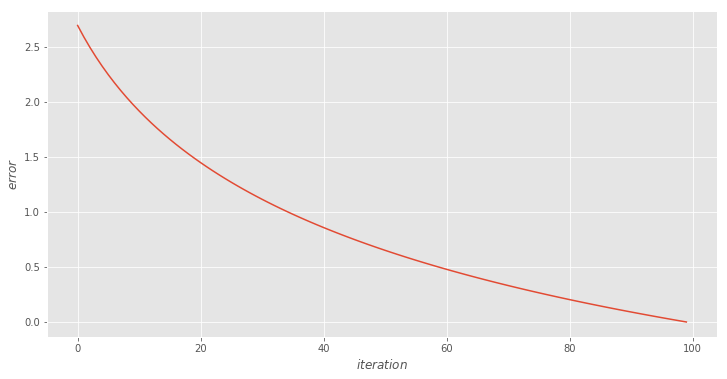

In [23]:
gd = GradientDescent().fit(R_t, U_t, U_ans, U_0[0])
print("Old R:\t\t{}".format(R))
print("Old U:\t\t{}".format(U_ans))
print("Target U:\t{}".format(U_t))
print("Calculated R:\t{}".format(gd.R))
print("Calculated U:\t{}".format(gd.U))
_ = plt.plot(gd.scores)
_ = plt.xlabel("$iteration$")
_ = plt.ylabel("$error$")

INFO:root:Max iter reached.
/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Old R:		[30. 40. 25. 80. 50. 40.]
Old U:		[ 8.33664152 15.80389043  7.32433505]
Target U:	[ 8.33664152 13.          7.32433505]
Calculated R:	[35.33356967 40.         25.         80.97703254 50.         46.24411959]
Calculated U:	[ 7.47425953 15.14601647  6.71757814]


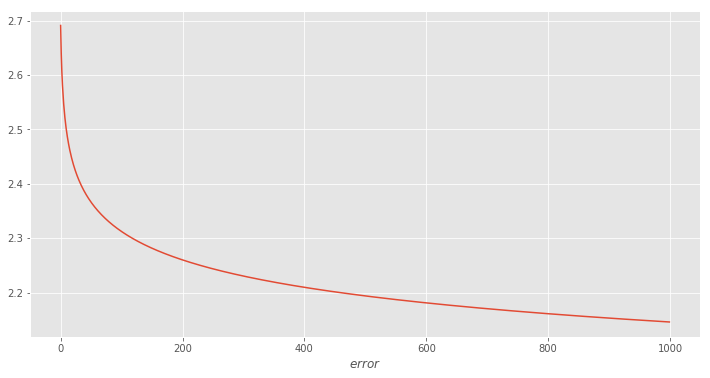

In [19]:
gd = GradientDescent().fit(R_t, U_t, U_ans, U_0[0], use_i=True)
print("Old R:\t\t{}".format(R))
print("Old U:\t\t{}".format(U_ans))
print("Target U:\t{}".format(U_t))
print("Calculated R:\t{}".format(gd.R))
print("Calculated U:\t{}".format(gd.U))
_ = plt.plot(gd.scores)
_ = plt.xlabel("$iteration$")
_ = plt.ylabel("$error$")

## 3. Гессиан

In [20]:
from functools import reduce

In [21]:
diff2 = calculate_diffs2(R_t, U_ans)[0]
gess_row = diff2[:, U_0[0]]
gess = reduce(lambda x, y: x * y, [x for x in gess_row if x != 0])
gess

9.048445e-12

Если определитель гессиана 
* \> 0: то данная точка - миниму;
* < 0: то данная точка - максимум;
* == 0: требуются дополнительные иссдедования. 

### Методы 0го порядка
<!--* равномерного поиска
* деления отрезка пополам
* дихотомии
* золотого сечения
* Фибоначчи
* квадратичной аппроксимации-->

In [36]:
# одномерной оптимизации
def onedim_optim(u_target, u_deriv, r, variable_g_inds, connection_matrix, eds_matrix, p, eps=0.1, eps_loss=1):
    step_optim = p
    while(np.linalg.norm(step_optim) > eps):
        is_inner = False
        # choose direction
        save_r = r[variable_g_inds]

        if all(r[variable_g_inds] + step_optim > 0):
            r[variable_g_inds] = r[variable_g_inds] + step_optim
            u_pred = LinearSolver.solve(*init_values(r))
            loss_p = MAE(u_target, u_pred[u_deriv])
        else:
            loss_p = 100000
        r[variable_g_inds] = save_r

        if all(r[variable_g_inds] - step_optim > 0):
            r[variable_g_inds] = r[variable_g_inds] - step_optim
            u_pred = LinearSolver.solve(*init_values(r))
            loss_m = MAE(u_target, u_pred[u_deriv])
        else:
            loss_m = 100000
        r[variable_g_inds] = save_r

        if loss_p < loss_m:
            step_ax = step_optim
            is_inner = True
        elif loss_p > loss_m:
            step_ax = -step_optim
            is_inner = True
        else:
            step_optim = step_optim/2
        # coord descent
        loss_prev = 100000000
        while(is_inner):
            save_r = r[variable_g_inds]
            if all(r[variable_g_inds] + step_ax > 0):
                r[variable_g_inds] = r[variable_g_inds] + step_ax
                u_pred = LinearSolver.solve(*init_values(r))
                loss_curr = MAE(u_target, u_pred[u_deriv])
                if loss_curr < loss_prev:
                    loss_prev = loss_curr
                if loss_prev - loss_curr < eps_loss:
                    return r
                else:
                    step_optim = step_optim/2
                    r[variable_g_inds] = save_r
                    break
            else:
                step_optim = step_optim/2
                break
    return r

In [25]:
# покоординатный спуск
def CoordDescent(u_target, u_deriv, r, variable_g_inds, connection_matrix, eds_matrix, learning_rate, iterations, eps=0.1):
    loss_val = list()
    step_optim = learning_rate
    u_pred = LinearSolver.solve(*init_values(r))
    loss_tmp = MAE(u_target, u_pred[u_deriv])
    loss_val.append(loss_tmp)
    for i in range(iterations):
        is_steped = False
        for j in variable_g_inds:
            # choose direction
            save_r = r[j]
            r[j] = r[j] + step_optim
            u_pred = LinearSolver.solve(*init_values(r))
            loss_p = MAE(u_target, u_pred[u_deriv])
            r[j] = save_r
            r[j] = r[j] - step_optim
            u_pred = LinearSolver.solve(*init_values(r))
            loss_m = MAE(u_target, u_pred[u_deriv])
            r[j] = save_r
            if loss_p < loss_m:
                step_ax = step_optim
            else:
                step_ax = -step_optim
            # coord descent
            loss_tmp = 0
            while(loss_tmp < loss_val[-1]):
                save_r = r[j]
                if r[j] + step_ax > 0:
                    r[j] = r[j] + step_ax
                else:
                    break
                u_pred = LinearSolver.solve(*init_values(r))
                loss_tmp = MAE(u_target, u_pred[u_deriv])
                if loss_tmp < loss_val[-1]:
                    is_steped = True
                    loss_val.append(loss_tmp)
                else:
                    r[j] = save_r
        # step reduction
        if not is_steped:
            step_optim = step_optim/2
        # converged
        if step_optim < eps:
            np.asarray(loss_val), r
    return np.asarray(loss_val), r

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


Old R:		[30. 40. 25. 80. 50. 40.]
Old U:		[ 8.33664152 15.80389043  7.32433505]
Target U:	[ 8.33664152 13.          7.32433505]
Calculated R:	[30.         10.41055718 25.         80.         50.         40.        ]
Calculated U:	[ 3.55 13.    4.2 ]
Final score:	0.0


/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


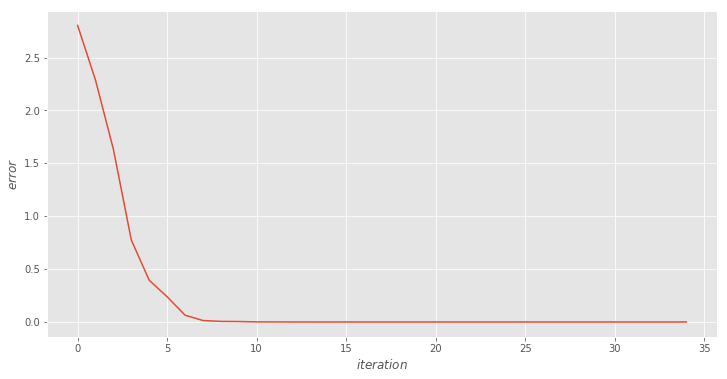

In [26]:
learning_rate = 8
iterations = 500
_scores, _R_pred = CoordDescent(U_0[1], U_0[0], R.copy(), R_0_idx.copy(), 
                              A.copy(), E.copy(), learning_rate, iterations)

U_pred = LinearSolver.solve(*init_values(_R_pred))
print("Old R:\t\t{}".format(R))
print("Old U:\t\t{}".format(U_ans))
print("Target U:\t{}".format(U_t))
print("Calculated R:\t{}".format(_R_pred))
print("Calculated U:\t{}".format(U_pred))
print("Final score:\t{}".format(MAE(U_0[1], U_pred[U_0[0]])))
_ = plt.plot(_scores)
_ = plt.xlabel("$iteration$")
_ = plt.ylabel("$error$")

In [169]:
def norm(x):
    return np.sqrt(np.sum(x**2))

In [183]:
# сопряженных направлений нулевого порядка (Пауэлла)
def conj_directions(u_target, u_deriv, r, variable_g_inds, connection_matrix, eds_matrix, eps=0.5):
    loss_val = list()
    r = r.copy()

    n = len(variable_g_inds)
    p = np.zeros((n, n+1))
    p_m = np.zeros((n, n+1))
    diag = np.diag_indices_from(p[:, 1:])
    p[:, 1:][diag] = 1
    p[:, 0] = p[:, len(variable_g_inds)]

    learning_rate = 8
    iterations = 500
    k = 0
    jdx = 0
    r_y = [r[variable_g_inds].copy()]
    is_stop = False
    while (not is_stop):
        print("iteration", jdx)
        jdx += 1 
        u_pred = LinearSolver.solve(*init_values(r))
        loss_tmp = MAE(u_target, u_pred[u_deriv])
        loss_val.append(loss_tmp)
        r_o = r.copy()
        print("loss", loss_tmp)
        for i in range(0, n+1):
            r_tmp = r.copy()
            r_tmp[variable_g_inds] = r_y[i].copy()
            new_r = onedim_optim(u_target, u_deriv, r_tmp, variable_g_inds, connection_matrix, eds_matrix,
                                 p[:, i])[variable_g_inds]
            r_y.append(new_r)
            if i == n-1:
                if all(r_y[i] == r_y[0]):
                    return np.asarray(loss_val), r_y[i]
            elif i == n:
                if all(r_y[i+1] == r_y[1]):
                    return np.asarray(loss_val), r_y[i]
                else:
                    if np.linalg.norm(r_y[i+1] - r_y[0]) < eps:
                        return np.asarray(loss_val), r_y[i+1]
                    else:
                        p_m[:, 0] = p_m[:, n] = r_y[i] - r_y[1]
                        for j in range(1, n):
                            p_m[:, j] = p[:, j+1]
                        if np.linalg.matrix_rank(p_m[:, 1:]) == n:
                            p = p_m.copy()
                        r[variable_g_inds] = r_y[i].copy()
                        r_y = [r[variable_g_inds].copy()]
                        k = k+1
                        if k == 1000:
                            is_stop = True
        print("new_r", new_r.mean())
#         print("norm", norm(r - r_o))
    return np.asarray(loss_val), r_y[-1]

Old R:		[30. 40. 25. 80. 50. 40.]
Old U:		[ 8.33664152 15.80389043  7.32433505]
Target U:	[ 8.33664152 13.          7.32433505]
iteration 0
loss 2.8038904327113947
new_r 38.0
iteration 1
loss 2.7452029446075876
new_r 37.0
iteration 2
loss 2.684931506849315
new_r 36.0
iteration 3
loss 2.6230111170806296
new_r 35.0
iteration 4
loss 2.5593731668482373
new_r 34.0
iteration 5
loss 2.4939451880178485
new_r 33.0
iteration 6
loss 2.4266505774866403
new_r 32.0
iteration 7
loss 2.3574082979932687
new_r 31.0
iteration 8
loss 2.2861325525685388
new_r 30.0
iteration 9
loss 2.2127324298770894
new_r 29.0
iteration 10
loss 2.13711151736746
new_r 28.0
iteration 11
loss 2.059167478769316
new_r 27.0
iteration 12
loss 1.9787915920444892
new_r 26.0
iteration 13
loss 1.8958682434049905
new_r 25.0
iteration 14
loss 1.8102743724460009
new_r 24.0
iteration 15
loss 1.721878862793572
new_r 23.0
iteration 16
loss 1.6305418719211833
new_r 22.0
iteration 17
loss 1.5361140929305321
new_r 21.0
iteration 18
loss 1.438

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


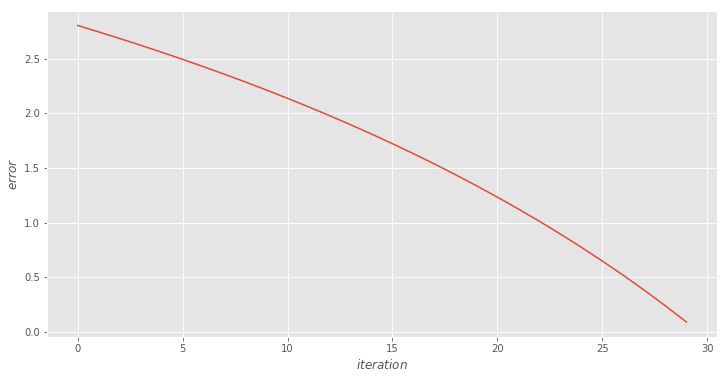

In [184]:
print("Old R:\t\t{}".format(R))
print("Old U:\t\t{}".format(U_ans))
print("Target U:\t{}".format(U_t))

scores, R_n = conj_directions(U_0[1], U_0[0], R.copy(), R_0_idx.copy(), A.copy(), E.copy())
R_pred = R.copy()
R_pred[U_0[0]] = R_n.mean()
U_pred = LinearSolver.solve(*init_values(R_pred))

print("Calculated R:\t{}".format(R_pred))
print("Calculated U:\t{}".format(U_pred))
print("Final score:\t{}".format(MAE(U_0[1], U_pred[U_0[0]])))  # невязка
_ = plt.plot(scores)
_ = plt.xlabel("$iteration$")
_ = plt.ylabel("$error$")

In [59]:
def Hooke_Jeeves(u_target, u_deriv, r, variable_g_inds, connection_matrix, eds_matrix, learning_rate, iterations, eps=1, lmbd=2):
    loss_val = list()
    step_optim = np.zeros(len(r),) + learning_rate
    u_pred = LinearSolver.solve(*init_values(r))
    loss_tmp = MAE(u_target, u_pred[u_deriv])
    loss_val.append(loss_tmp)
    for i in range(iterations):
        root_r = r.copy()
        step_stop = [False]*len(variable_g_inds)
        print("iteration", i)
        for k, j in enumerate(variable_g_inds):
            is_step = False
            step_ax = step_optim.copy()
            while (not is_step):
                save_r = r[j]

                if r[j] + step_ax[j] > 0:
                    r[j] = r[j] + step_ax[j]
                    u_pred = LinearSolver.solve(*init_values(r))
                    loss_p = MAE(u_target, u_pred[u_deriv])
                    print("loss p0:", loss_p)
                else:
                    loss_p = 10000000
                r[j] = save_r

                if r[j] - step_ax[j] > 0:
                    r[j] = r[j] - step_ax[j]
                    u_pred = LinearSolver.solve(*init_values(r))
                    loss_m = MAE(u_target, u_pred[u_deriv])
                    print("loss p1:", loss_m)
                else:
                    loss_m = 10000000
                r[j] = save_r

                # choose direct
                m = np.array([loss_m, loss_p, loss_val[-1]]).argmin()
                if m == 0:
                    if r[j] - step_ax[j] > 0:
                        r[j] = r[j] - step_ax[j]
                        # print("make step to", -step_ax[j])
                        is_step = True
                elif m == 1:
                    if r[j] + step_ax[j] > 0:
                        r[j] = r[j] + step_ax[j]
                        # print("make step to", step_ax[j])
                        is_step = True
                else:
                    new_step = step_ax[j]/2
                    if new_step > eps:
                        step_ax[j] = step_ax[j]/2
                    else:
                        is_step = True
                        step_stop[k] = True
                    print("new step", new_step)
        if all(step_stop):
            u_pred = LinearSolver.solve(*init_values(r))
            loss_tmp = MAE(u_target, u_pred[u_deriv])
            loss_val.append(loss_tmp)
            print("final loss:", loss_tmp)
            return np.asarray(loss_val), r
        is_founded = True
        while (is_founded):
            is_founded = False
            if all(root_r + lmbd*(r - root_r) > 0):
                root2_r = root_r + lmbd*(r - root_r)
                u_pred = LinearSolver.solve(*init_values(root2_r))
                loss_root2 = MAE(u_target, u_pred[u_deriv])
                r4 = root2_r.copy()
                for j in variable_g_inds:
                    save_r = r4[j]

                    if r4[j] + step_ax[j] > 0:
                        r4[j] = r4[j] + step_ax[j]
                        u_pred = LinearSolver.solve(*init_values(r4))
                        loss_p = MAE(u_target, u_pred[u_deriv])
                        # print("loss x0", loss_p)
                    else:
                        loss_p = 10000000
                    r4[j] = save_r

                    if r4[j] - step_ax[j] > 0:
                        r4[j] = r4[j] - step_ax[j]
                        u_pred = LinearSolver.solve(*init_values(r4))
                        loss_m = MAE(u_target, u_pred[u_deriv])
                        # print("loss x1", loss_m)
                    else:
                        loss_m = 10000000
                    r4[j] = save_r
                    # choose direct
                    m = np.array([loss_m, loss_p, loss_root2]).argmin()
                    if m == 0:
                        if r4[j] - step_ax[j] > 0:
                            r4[j] = r4[j] - step_ax[j]
                    elif m == 1:
                        if r4[j] + step_ax[j] > 0:
                            r4[j] = r4[j] + step_ax[j]
                u_pred = LinearSolver.solve(*init_values(r4))
                loss_r4 = MAE(u_target, u_pred[u_deriv])
                if (loss_r4 < loss_root2):
                    is_founded = True
                    root_r = r.copy()
                    r = r4.copy()
        u_pred = LinearSolver.solve(*init_values(r))
        print("mate step to", r)
        print("values", u_pred)
        loss_tmp = MAE(u_target, u_pred[u_deriv])
        loss_val. append(loss_tmp)
        print("loss:", loss_tmp)
    return np.asarray(loss_val), r

iteration 0
loss p0: 2.861055601269541
loss p1: 2.7452029446075876
loss p0: 2.8038904327113947
loss p1: 2.684931506849315
loss p0: 2.7452029446075876
loss p1: 2.6230111170806296
loss p0: 2.684931506849315
loss p1: 2.5593731668482373
loss p0: 2.6230111170806296
loss p1: 2.4939451880178485
loss p0: 2.5593731668482373
loss p1: 2.4266505774866403
mate step to [30. 22. 25. 80. 50. 40.]
values [ 6.00561564 14.43843594  5.80282862]
loss: 1.438435940099831
iteration 1
loss p0: 1.5361140929305321
loss p1: 1.3373366488545582
loss p0: 1.438435940099831
loss p1: 1.2326332794830357
loss p0: 1.3373366488545582
loss p1: 1.1241296123690976
loss p0: 1.2326332794830357
loss p1: 1.0116149207058314
loss p0: 1.1241296123690976
loss p1: 0.8948626045400232
loss p0: 1.0116149207058314
loss p1: 0.7736286675171069
mate step to [30. 16. 25. 80. 50. 40.]
values [ 4.87069465 13.77362867  5.06204337]
loss: 0.7736286675171069
iteration 2
loss p0: 0.8948626045400232
loss p1: 0.6476500147797815
loss p0: 0.773628667517

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


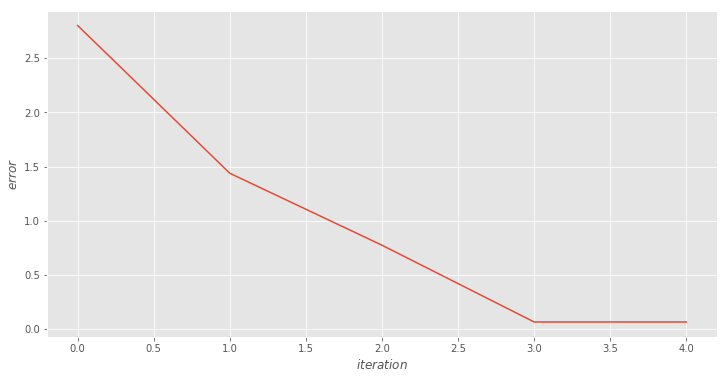

In [60]:
print("Old R:\t\t{}".format(R))
print("Old U:\t\t{}".format(U_ans))
print("Target U:\t{}".format(U_t))

learning_rate = 1
iterations = 5
scores, R_pred = Hooke_Jeeves(U_0[1], U_0[0], R.copy(), R_0_idx.copy(), 
                              A.copy(), E.copy(), learning_rate, iterations)

U_pred = LinearSolver.solve(*init_values(R_pred))
print("Calculated R:\t{}".format(R_pred))
print("Calculated U:\t{}".format(U_pred))
print("Final score:\t{}".format(MAE(U_0[1], U_pred[U_0[0]])))
_ = plt.plot(scores)
_ = plt.xlabel("$iteration$")
_ = plt.ylabel("$error$")

In [166]:
def AdaptiveRandom(u_target, u_deriv, r, variable_g_inds, iterations, eps=0.01, alpha=1.1, beta=0.9):
    loss_val = list()
    k = 0
    step = 1
    min_step = 0.001
    r_i = r.copy()
    while (k < iterations):
        if k == iterations - 1:
            print('last iter')
        for i in range(iterations):
            loss_val.append(MAE(u_target, LinearSolver.solve(*init_values(r_i))[u_deriv]))
            phi = np.random.normal(0, 0.4, size=(len(variable_g_inds)))
            y_i = r_i + step*(phi/norm(phi))
            loss_val.append(MAE(u_target, LinearSolver.solve(*init_values(y_i))[u_deriv]))
            if loss_val[-1] < eps:
                print('oiptimal')
                k = iterations
                break
            k += 1
            if loss_val[-1] < loss_val[-2]:
                # print("successful step")
                z_i = r_i + alpha*(y_i - r_i)
                loss_val.append(MAE(u_target, LinearSolver.solve(*init_values(z_i))[u_deriv]))
                if loss_val[-1] < loss_val[-3]:
                    # print("successful dir")
                    r_i = z_i
                    step *= alpha
                else:
                    # print("unsuccessful dir")
                    if i >= iterations:
                        if step <= min_step:
                            k = iterations
                            break
                        else:
                            step *= step
                            break
            else:
                # print("unsuccessful step")
                if i >= iterations:
                    if step <= min_step:
                        k = iterations
                        break
                    else:
                        step *= step
                        break
    return np.asarray(loss_val), r

Old R:		[30. 40. 25. 80. 50. 40.]
Old U:		[ 8.33664152 15.80389043  7.32433505]
Target U:	[ 8.33664152 13.          7.32433505]
Calculated R:	[30. 40. 25. 80. 50. 40.]
Calculated U:	[ 8.33664152 15.80389043  7.32433505]
Final score:	2.8038904327113947


/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


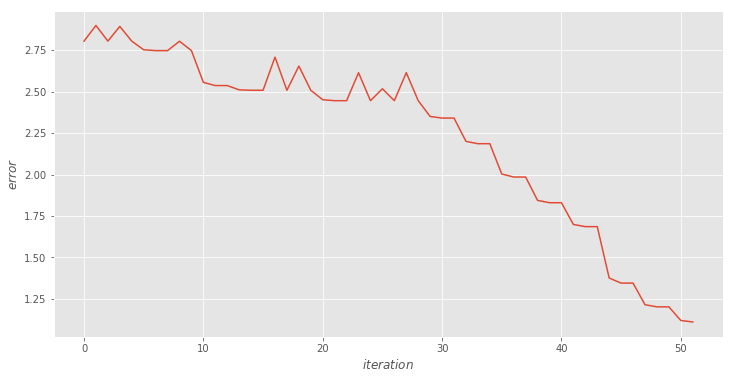

In [168]:
print("Old R:\t\t{}".format(R))
print("Old U:\t\t{}".format(U_ans))
print("Target U:\t{}".format(U_t))

iterations = 20
scores, R_pred = AdaptiveRandom(U_0[1], U_0[0], R.copy(), R_0_idx.copy(), iterations)

U_pred = LinearSolver.solve(*init_values(R_pred))
print("Calculated R:\t{}".format(R_pred))
print("Calculated U:\t{}".format(U_pred))
print("Final score:\t{}".format(MAE(U_0[1], U_pred[U_0[0]])))
_ = plt.plot(scores)
_ = plt.xlabel("$iteration$")
_ = plt.ylabel("$error$")

In [37]:
def grad_i_calc(u_target, u_pred, r, variable_g_inds, u_deriv):
    grad = np.zeros((len(r)),)
    for var in variable_g_inds:
        deriv = LinearSolver.solve(*init_values(r))[u_deriv]
        grad[var] = 2*(u_pred[u_deriv] - u_target)*deriv
    return grad

In [31]:
def get_Hesse_matrix(r, variable_g_inds):
    hesse = np.zeros((len(variable_g_inds), len(variable_g_inds)))
    i = np.diag_indices_from(hesse)
    hesse[i] = 2/(r[variable_g_inds]**3)
    return hesse

def Newton(u_target, u_deriv, r, variable_g_inds, connection_matrix, eds_matrix, iterations, eps_grad=0.1, eps_r=0.1):
    loss_val = []
    k = 0
    # g = 1/r
    while True:
        u_pred = LinearSolver.solve(*init_values(r))
        loss_tmp = MAE(u_target, u_pred[u_deriv])
        loss_val.append(loss_tmp)
        grad = grad_i_calc(u_target, u_pred, r, variable_g_inds, u_deriv)[variable_g_inds]
        if np.linalg.norm(grad) < eps_grad:
            return np.asarray(loss_val), r
        if k > iterations:
            return np.asarray(loss_val), r
        hesse = get_Hesse_matrix(r, variable_g_inds)
        try:
            hesse_inv = np.linalg.inv(hesse)
        except Exception:
            return np.asarray(loss_val), r

        dets = []
        for i in range(len(hesse_inv)):
            if (np.linalg.det(hesse_inv[i:, i:]) > 0):
                dets.append(True)
            else:
                dets.append(False)
        if all(dets):
            p = np.matmul(-hesse_inv, grad)
            tmp_r = np.zeros((len(r), ))
            tmp_r[variable_g_inds] = p
            is_step = False
            while(not is_step):
                if all(r + tmp_r > 0):
                    new_r = r + tmp_r
                    if any(new_r > 100000000):
                        return np.asarray(loss_val), r
                    is_step = True
                else:
                    tmp_r = tmp_r/2
        else:
            p = -grad
            new_r = onedim_optim(
                u_target, u_deriv, r, variable_g_inds, connection_matrix, eds_matrix, p)

        if np.linalg.norm(new_r - r) < eps_r:
            u1 = LinearSolver.solve(*init_values(r))
            loss1 = MAE(u_target, u1[u_deriv])
            u2 = LinearSolver.solve(*init_values(new_r))
            loss2 = MAE(u_target, u2[u_deriv])
            if np.linalg.norm(loss2 - loss1) < eps_r:
                print('eps_r')
                return np.asarray(loss_val), r

        r = new_r.copy()
        k = k+1

Old R:		[30. 40. 25. 80. 50. 40.]
Old U:		[ 8.33664152 15.80389043  7.32433505]
Target U:	[ 8.33664152 13.          7.32433505]
Calculated R:	[30.          7.17847014 25.         80.         50.         40.        ]
Calculated U:	[ 2.63065577 12.461472    3.59992594]
Final score:	0.5385280009323612


/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


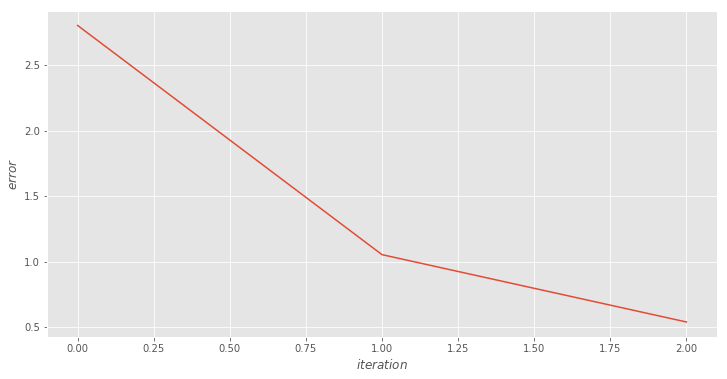

In [32]:
iterations = 1
scores, R_pred = Newton(U_0[1], U_0[0], R.copy(), R_0_idx.copy(), A.copy(), E.copy(), iterations)

U_pred = LinearSolver.solve(*init_values(R_pred))
print("Old R:\t\t{}".format(R))
print("Old U:\t\t{}".format(U_ans))
print("Target U:\t{}".format(U_t))
print("Calculated R:\t{}".format(R_pred))
print("Calculated U:\t{}".format(U_pred))
print("Final score:\t{}".format(MAE(U_0[1], U_pred[U_0[0]])))
_ = plt.plot(scores)
_ = plt.xlabel("$iteration$")
_ = plt.ylabel("$error$")

In [34]:
def Marquardt(u_target, u_deriv, r, variable_g_inds, connection_matrix, eds_matrix, iterations, eps_grad=0.1, eps_r=0.1):
    tmp_r = np.zeros((len(r), ))
    loss_val = []
    k = 0
    mu = 1
    while (True):
        u_pred = LinearSolver.solve(*init_values(r))
        loss_tmp = MAE(u_target, u_pred[u_deriv])
        loss_val.append(loss_tmp)
        grad = grad_i_calc(u_target, u_pred, r, variable_g_inds, u_deriv)[variable_g_inds]
        if np.linalg.norm(grad) < eps_grad:
            return np.asarray(loss_val), r
        if k > iterations:
            return np.asarray(loss_val), r
        hesse = get_Hesse_matrix(r, variable_g_inds)
        hesse_E = hesse + mu*np.eye(len(hesse))
        hesse_E_inv = np.linalg.inv(hesse_E)
        p = np.matmul(-hesse_E_inv, grad)
        tmp_r[variable_g_inds] = p
        new_r = r + tmp_r

        u_new_pred = LinearSolver.solve(*init_values(new_r))
        loss_new_tmp = MAE(u_target, u_new_pred[u_deriv])

        to_next_step = False
        while(not to_next_step):
            if(loss_new_tmp <= loss_tmp):
                to_next_step = True
                k = k+1
                mu = mu/2
                r = new_r.copy()
            else:
                mu = 2*mu
                print(new_r)
                hesse_E = hesse + mu*np.eye(len(hesse))
                hesse_E_inv = np.linalg.inv(hesse_E)
                p = np.matmul(-hesse_E_inv, grad)
                tmp_r[variable_g_inds] = p
                new_r = r + tmp_r

                u_new_pred = LinearSolver.solve(*init_values(new_r))
                loss_new_tmp = MAE(u_target, u_new_pred[u_deriv])

[ 30.         -48.62198493  25.          80.          50.
  40.        ]
[30.         -4.31168481 25.         80.         50.         40.        ]
[30.          3.94112075 25.         80.         50.         40.        ]
[30.          9.92692268 25.         80.         50.         40.        ]
Old R:		[30. 40. 25. 80. 50. 40.]
Old U:		[ 8.33664152 15.80389043  7.32433505]
Target U:	[ 8.33664152 13.          7.32433505]
Calculated R:	[30.         10.40924517 25.         80.         50.         40.        ]
Calculated U:	[ 3.54965273 12.99979658  4.19977333]
Final score:	0.00020342155542429907


/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


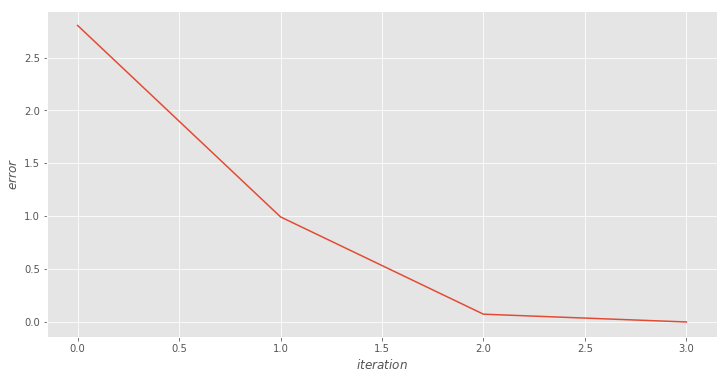

In [35]:
iterations = 1000
scores, R_pred = Marquardt(U_0[1], U_0[0], R.copy(), R_0_idx.copy(), A.copy(), E.copy(), iterations)

U_pred = LinearSolver.solve(*init_values(R_pred))
print("Old R:\t\t{}".format(R))
print("Old U:\t\t{}".format(U_ans))
print("Target U:\t{}".format(U_t))
print("Calculated R:\t{}".format(R_pred))
print("Calculated U:\t{}".format(U_pred))
print("Final score:\t{}".format(MAE(U_0[1], U_pred[U_0[0]])))
_ = plt.plot(scores)
_ = plt.xlabel("$iteration$")
_ = plt.ylabel("$error$")

In [29]:
# сопряженных направлений Флетчера Ривза
def conj_grad(u_target, u_deriv, r, variable_g_inds, connection_matrix, eds_matrix, iterations, eps_grad=0.1, eps_r=0.01):
    loss_val = list()
    k = 0
    grad_lst = []
    p = []
    # g = 1/r
    while(True):
        u_pred = LinearSolver.solve(*init_values(r))
        loss_tmp = MAE(u_target, u_pred[u_deriv])
        loss_val. append(loss_tmp)

        grad = grad_i_calc(u_target, u_pred, r, variable_g_inds, u_deriv)[variable_g_inds]
        grad_lst.append(grad)
        if np.linalg.norm(grad) < eps_grad:
            print('eps_g')
            return np.asarray(loss_val), r
        if k >= iterations:
            print('iter')
            return np.asarray(loss_val), r
        if k == 0:
            p.append(-grad_lst[k])
            new_r = onedim_optim(
                u_target, u_deriv, r, variable_g_inds, connection_matrix, eds_matrix, p[k])
        else:
            beta = np.linalg.norm(grad_lst[k])**2/np.linalg.norm(grad_lst[k-1])**2
            p.append(grad + beta*p[k-1])
            new_r = onedim_optim(u_target, u_deriv, r.copy(), 
                                 variable_g_inds, connection_matrix, eds_matrix, p[k])

            if np.linalg.norm(new_r - r) < eps_r:
                u1 = LinearSolver.solve(*init_values(r))
                loss1 = MAE(u_target, u1[u_deriv])
                u2 = LinearSolver.solve(*init_values(new_r))
                loss2 = MAE(u_target, u2[u_deriv])
                if np.linalg.norm(loss2 - loss1) < eps_r:
                    print('eps_r')
                    return np.asarray(loss_val), r
        r = new_r.copy()
        k = k+1

iter
Old R:		[30. 40. 25. 80. 50. 40.]
Old U:		[ 8.33664152 15.80389043  7.32433505]
Target U:	[ 8.33664152 13.          7.32433505]
Calculated R:	[30.         10.41055718 25.         80.         50.         40.        ]
Calculated U:	[ 3.55 13.    4.2 ]
Final score:	0.0


/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


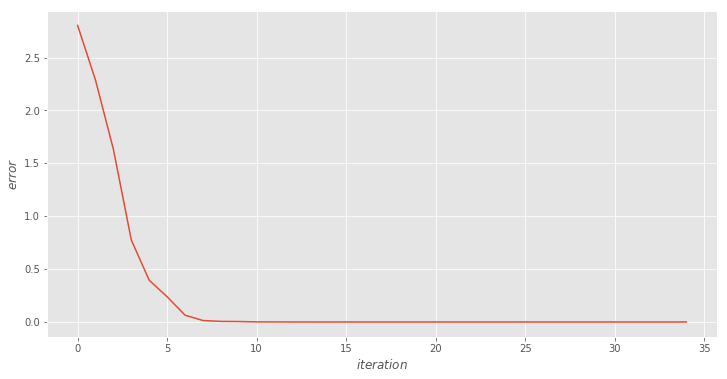

In [30]:
iterations = 1000
scores_, R_pred_ = conj_grad(U_0[1], U_0[0], R.copy(), R_0_idx.copy(), 
                             A.copy(), E.copy(), iterations)

U_pred = LinearSolver.solve(*init_values(_R_pred))
print("Old R:\t\t{}".format(R))
print("Old U:\t\t{}".format(U_ans))
print("Target U:\t{}".format(U_t))
print("Calculated R:\t{}".format(_R_pred))
print("Calculated U:\t{}".format(U_pred))
print("Final score:\t{}".format(MAE(U_0[1], U_pred[U_0[0]])))
_ = plt.plot(_scores)
_ = plt.xlabel("$iteration$")
_ = plt.ylabel("$error$")

In [180]:
# Многокритериальная задача методом Ньютона
def Newton_2dim(u_target, u_deriv, r, variable_g_inds, connection_matrix, eds_matrix, iterations, eps_grad=0.1, eps_r=0.1, lm0=0.1, lm1=0.9):
    loss0_val = []
    loss1_val = []
    k = 0
    while True:
        u_pred = LinearSolver.solve(*init_values(r))
        loss_tmp0 = MAE(u_target[0], u_pred[u_deriv[0]])
        loss_tmp1 = MAE(u_target[1], u_pred[u_deriv[1]])
        loss0_val.append(loss_tmp0)
        loss1_val.append(loss_tmp1)
        grad0 = grad_i_calc(u_target[0], u_pred, r, variable_g_inds, u_deriv[0])[variable_g_inds]
        grad1 = grad_i_calc(u_target[1], u_pred, r, variable_g_inds, u_deriv[1])[variable_g_inds]
        grad = lm0*grad0 + lm1*grad1
        if np.linalg.norm(grad) < eps_grad:
            print('eps_g')
            return np.asarray(loss0_val), np.asarray(loss1_val), r
        if k > iterations:
            print('eiter')
            return np.asarray(loss0_val), np.asarray(loss1_val), r
        hesse = get_Hesse_matrix(r, variable_g_inds)
        try:
            hesse_inv = np.linalg.inv(hesse)
        except Exception:
            print('exc')
            return np.asarray(loss0_val), np.asarray(loss1_val), r
            
        dets = []
        for i in range(len(hesse_inv)):
            if (np.linalg.det(hesse_inv[i:,i:]) > 0):
                dets.append(True)
            else:
                dets.append(False)
        if all(dets):
            p = np.matmul(-hesse_inv, grad)
            tmp_r = np.zeros((len(r), ))
            tmp_r[variable_g_inds] = p
            is_step = False
            while(not is_step):
                if all(r + tmp_r > 0):
                    new_r = r + tmp_r
#                     if any(new_r > 10000000000000):
#                         print('r_roof')
#                         return np.asarray(loss_val), r
                    is_step = True
                else:
                    tmp_r = tmp_r/2
        else:
            p = -grad
            new_r = onedim_optim(u_target, u_deriv, r, variable_g_inds, connection_matrix, eds_matrix, p)
        
        if np.linalg.norm(new_r - r) < eps_r:
            u1 = LinearSolver.solve(*init_values(r))
            loss10 = MAE(u_target[0], u1[u_deriv[0]])
            loss11 = MAE(u_target[1], u1[u_deriv[1]])
            loss1 = lm0*loss10 + lm1*loss11
            u2 = LinearSolver.solve(*init_values(new_r))
            loss20 = MAE(u_target[0], u2[u_deriv[0]])
            loss21 = MAE(u_target[1], u2[u_deriv[1]])
            loss2 = lm0*loss20 + lm1*loss21
            if np.linalg.norm(loss2 - loss1) < eps_r:
                print('eps_r')
                return np.asarray(loss0_val), np.asarray(loss1_val), r
        
        r = new_r.copy()
        k=k+1

eiter
Old R:		[30. 40. 25. 80. 50. 40.]
Old U:		[ 8.33664152 15.80389043  7.32433505]
Target U:	[ 8.33664152 13.          7.32433505]
Calculated R:	[ 30.         323.28241389  25.          80.          50.
  40.        ]
Calculated U:	[14.26767745 19.27813742 11.19563884]


/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


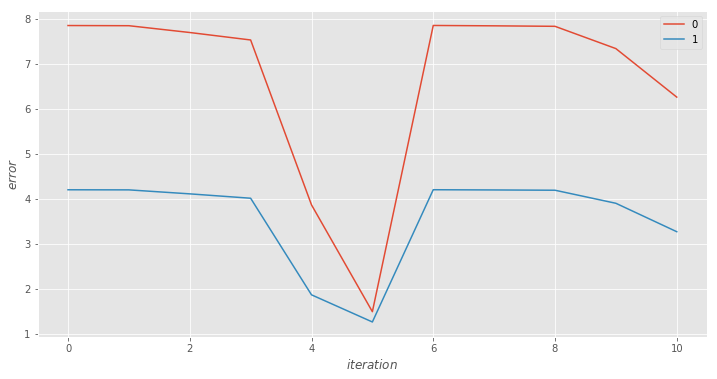

In [182]:
iterations = 10
U_1 = ((0, 1), (8, 16))
U_t1 = U_ans.copy()
U_t1[U_1[0][0]] = U_1[1][0]
U_t1[U_1[0][1]] = U_1[1][1]
scores0_, scores1_, R_pred_ = Newton_2dim(U_1[1], U_1[0], R.copy(), R_0_idx.copy(), 
                                          A.copy(), E.copy(), iterations)

U_pred = LinearSolver.solve(*init_values(R_pred_))
print("Old R:\t\t{}".format(R))
print("Old U:\t\t{}".format(U_ans))
print("Target U:\t{}".format(U_t))
print("Calculated R:\t{}".format(R_pred_))
print("Calculated U:\t{}".format(U_pred))
_ = plt.plot(scores0_[1:])
_ = plt.plot(scores1_[1:])
_ = plt.legend((str(U_1[0][0]), str(U_1[0][1])))
_ = plt.xlabel("$iteration$")
_ = plt.ylabel("$error$")

<!--TODO:
* Розенброка
* Наискорейший спуск
* средней точки
* хорд-->